<a href="https://colab.research.google.com/github/isaac-chisaleCS/code-unza25-csc4792-project_team_12-repository/blob/main/Copy_of_code_unza25_csc4792_project_team_12_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Business Understanding



#1.1 Background
Academic publications are essential for tracking research productivity, promoting collaboration, and enhancing institutional visibility. However, the challenge of author name ambiguity makes it difficult for universities to accurately identify which publications belong to their faculty members. This is because multiple authors may share the same or similar names, affiliations may be missing or outdated, and authors may change institutions over time.

The University of Zambia (UNZA) needs a reliable and efficient way to identify publications authored by its faculty members across multiple academic databases. This will support accurate reporting of research output, strengthen the institution’s academic profile, and enable better decision-making in research management.

The focus of this project is to develop a Data-driven classification model that can predict whether a given publication belongs to a UNZA faculty member. The system will analyze publication metadata such as author names, affiliations, email domains, co-author networks, and research topics to make this determination.



## 1.2 Business Objectives
The main objective is to automatically identify publications that belong to UNZA faculty members. This will:

- Reduce the time and effort required for manual verification of research outputs.
- Improve the completeness and accuracy of institutional publication records.
- Enhance research visibility for UNZA by ensuring faculty work is properly credited.
- Support strategic decision-making in research funding, performance evaluation, and collaborations.


## 1.3 Business Success Criteria
The success of the project will be measured by:
1.	Classification Accuracy – The automated system should correctly identify at least 80% of publications as belonging or not belonging to UNZA faculty members.
2.	Practical Usability – The system should allow research administrators and other stakeholders to process and verify publications with minimal effort.
3.	Interpretability – The model should provide explanations for its predictions to build trust in the system’s decisions


## 1.4 Data Mining Goals
- Develop a classification model that can predict whether a publication belongs to a UNZA faculty member based on its metadata.
- Apply supervised machine learning techniques using labeled examples of UNZA and non-UNZA publications.
- Extract and engineer features such as presence of "University of Zambia" in affiliations, "@unza.zm" in email addresses, and frequent co-authorship with known UNZA staff.
- Evaluate model performance using metrics such as accuracy, precision, recall, and F1-score.


## 1.5 Data Mining Success Criteria

The data mining task will be considered successful if:
- The classification model achieves at least 80% accuracy on a held-out test dataset.
-Precision and recall are both at least 75%, ensuring both correctness and completeness of UNZA punlication identification.
-The system can process new, unseen publication data with consistent performance.

#2. Data Understanding

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import re
from urllib.parse import urljoin, urlparse
import os
from google.colab import drive

class UNZAPublicationsScraper:
    def __init__(self):
        self.base_unza = "https://www.unza.zm"
        self.base_journals = "https://journals.unza.zm"
        self.base_dspace = "https://dspace.unza.zm"

        # Mount Google Drive # REMOVED: Redundant mount call
        # drive.mount('/content/drive')
        self.output_path = '/content/drive/MyDrive/unza_author_disambiguation_dataset.csv'

        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        })

    def load_existing_data(self):
        """Load existing data from Google Drive if file exists"""
        try:
            if os.path.exists(self.output_path):
                existing_df = pd.read_csv(self.output_path)
                print(f" Loaded existing data with {len(existing_df)} records")
                return existing_df
            return pd.DataFrame()
        except Exception as e:
            print(f" Error loading existing data: {e}")
            return pd.DataFrame()

    def save_new_data(self, new_data):
        """Append new data to existing CSV in Google Drive"""
        try:
            # Load existing data
            existing_df = self.load_existing_data()

            # Combine with new data
            if not existing_df.empty:
                # Remove duplicates based on title + authors
                combined_df = pd.concat([existing_df, new_data])
                combined_df = combined_df.drop_duplicates(
                    subset=['title', 'authors'],
                    keep='first'
                )
                print(f" Found {len(new_data) - (len(combined_df) - len(existing_df))} duplicates")
            else:
                combined_df = new_data

            # Save to Drive
            combined_df.to_csv(self.output_path, index=False)
            print(f" Saved {len(combined_df)} records to {self.output_path}")

            return combined_df

        except Exception as e:
            print(f" Error saving data: {e}")
            return pd.DataFrame()

    def scrape_inesor_publications(self):
        """Scrape INESOR publications page"""
        url = "https://www.unza.zm/institutes/inesor/research/publications"
        publications = []

        try:
            print(f"Scraping INESOR publications: {url}")
            response = self.session.get(url)

            if response.status_code == 200:
                soup = BeautifulSoup(response.text, 'html.parser')
                text_content = soup.get_text()

                # Split by common publication separators
                potential_pubs = re.split(r'\n\s*\n|\.\s*(?=[A-Z][a-z]+,?\s+[A-Z]\.)', text_content)

                for pub_text in potential_pubs:
                    pub_text = pub_text.strip()
                    if len(pub_text) > 50 and self.looks_like_publication(pub_text):
                        parsed_pub = self.parse_publication_text(pub_text)
                        if parsed_pub:
                            parsed_pub['source'] = 'INESOR'
                            parsed_pub['is_unza_faculty'] = 1
                            publications.append(parsed_pub)

                print(f"Found {len(publications)} INESOR publications")
            return publications

        except Exception as e:
            print(f"Error scraping INESOR: {e}")
            return []

    def scrape_unza_journals(self):
        """Scrape UNZA journals for faculty publications"""
        publications = []
        journal_urls = [
            "https://journals.unza.zm/index.php/JONAS",
            "https://journals.unza.zm/index.php/ZIJE",
        ]

        for journal_url in journal_urls:
            try:
                print(f"Scraping journal: {journal_url}")
                response = self.session.get(journal_url)

                if response.status_code == 200:
                    soup = BeautifulSoup(response.text, 'html.parser')
                    article_links = soup.find_all('a', href=re.compile(r'/article/view/'))

                    for link in article_links[:10]:  # Limit per journal
                        article_url = urljoin(journal_url, link.get('href'))
                        article_data = self.scrape_journal_article(article_url)

                        if article_data:
                            article_data['source'] = 'UNZA_Journal'
                            article_data['is_unza_faculty'] = 1
                            publications.append(article_data)

                        time.sleep(2)

                print(f"Found {len(publications)} journal publications so far")
                time.sleep(5)

            except Exception as e:
                print(f"Error scraping journal {journal_url}: {e}")
                continue

        return publications

    def scrape_journal_article(self, article_url):
        """Extract data from individual journal article"""
        try:
            response = self.session.get(article_url)
            if response.status_code != 200:
                return None

            soup = BeautifulSoup(response.text, 'html.parser')

            article_data = {
                'title': '',
                'authors': '',
                'publication_venue': '',
                'year': '',
                'abstract': '',
                'keywords': ''
            }

            # Extract title
            title_elem = soup.find('h1') or soup.find('title')
            if title_elem:
                article_data['title'] = title_elem.get_text(strip=True)

            # Extract authors
            author_meta = soup.find('meta', {'name': 'citation_author'}) or \
                         soup.find('meta', {'name': 'DC.creator'})
            if author_meta:
                article_data['authors'] = author_meta.get('content', '').strip()

            # Extract year
            date_meta = soup.find('meta', {'name': 'citation_publication_date'}) or \
                       soup.find('meta', {'name': 'DC.date'})
            if date_meta:
                date_text = date_meta.get('content', '')
                year_match = re.search(r'\b(19|20)\d{2}\b', date_text)
                if year_match:
                    article_data['year'] = year_match.group()

            # Extract abstract
            abstract_elem = soup.find('div', class_=re.compile(r'abstract')) or \
                           soup.find('meta', {'name': 'description'})
            if abstract_elem:
                if abstract_elem.name == 'meta':
                    article_data['abstract'] = abstract_elem.get('content', '').strip()
                else:
                    article_data['abstract'] = abstract_elem.get_text(strip=True)

            # Extract journal name
            journal_meta = soup.find('meta', {'name': 'citation_journal_title'})
            if journal_meta:
                article_data['publication_venue'] = journal_meta.get('content', '').strip()

            return article_data

        except Exception as e:
            print(f"Error scraping article {article_url}: {e}")
            return None

    def looks_like_publication(self, text):
        """Check if text looks like a academic publication citation"""
        patterns = [
            r'[A-Z][a-z]+,?\s+[A-Z]\.',  # Author pattern
            r'\(\d{4}\)',                 # Year in parentheses
            r'\d{4}\.?\s',               # Year followed by period/space
            r'pp?\.\s*\d+',              # Page numbers
            r'Vol\.\s*\d+',              # Volume
        ]
        return sum(1 for pattern in patterns if re.search(pattern, text)) >= 2

    def parse_publication_text(self, pub_text):
        """Parse a publication citation text into structured data"""
        try:
            pub_data = {
                'title': '',
                'authors': '',
                'publication_venue': '',
                'year': '',
                'abstract': '',
                'keywords': ''
            }

            # Extract year
            year_match = re.search(r'\b(19|20)\d{2}\b', pub_text)
            if year_match:
                pub_data['year'] = year_match.group()

            # Extract authors
            author_match = re.match(r'^([^.]+?)[\.(]', pub_text)
            if author_match:
                pub_data['authors'] = author_match.group(1).strip()

            # Extract title
            title_patterns = [
                r'"([^"]+)"',                    # Title in quotes
                r'[.]\s*([^.]+?)[.]\s*[A-Z]',   # Title between periods
                r'\(\d{4}\)[.]?\s*([^.]+?)[.]'  # Title after year
            ]

            for pattern in title_patterns:
                title_match = re.search(pattern, pub_text)
                if title_match:
                    pub_data['title'] = title_match.group(1).strip()
                    break

            # Fallback for title
            if not pub_data['title'] and len(pub_text) > 20:
                words = pub_text.split()
                if len(words) > 10:
                    pub_data['title'] = ' '.join(words[3:10])

            return pub_data if pub_data['authors'] else None

        except Exception as e:
            print(f"Error parsing publication: {e}")
            return None

    def get_external_publications_for_comparison(self, search_terms, max_per_term=10):
        """Get non-UNZA publications for negative examples"""
        all_pubs = []

        for term in search_terms:
            print(f"Getting non-UNZA publications for: {term}")
            fake_pubs = self.generate_sample_non_unza_publications(term, max_per_term)

            for pub in fake_pubs:
                pub['source'] = 'External'
                pub['is_unza_faculty'] = 0
                all_pubs.append(pub)

        return all_pubs

    def generate_sample_non_unza_publications(self, topic, count):
        """Generate sample non-UNZA publications (replace with real scraping)"""
        sample_authors = [
            "Smith, J.K.", "Johnson, M.A.", "Williams, P.R.", "Brown, S.L.", "Davis, K.M.",
            "Wilson, T.A.", "Moore, R.J.", "Taylor, L.S.", "Anderson, C.D.", "Thomas, N.P."
        ]

        publications = []
        for i in range(count):
            pub = {
                'title': f"Research on {topic} - Study {i+1}",
                'authors': sample_authors[i % len(sample_authors)],
                'publication_venue': f"International Journal of {topic.title()}",
                'year': str(2018 + (i % 7)),
                'abstract': f"This study investigates {topic} using advanced methodologies...",
                'keywords': f"{topic}, research, methodology"
            }
            publications.append(pub)

        return publications

def scrape_unza_faculty_publications(max_external_pubs=50):
    """Main scraping function with Google Drive save"""
    scraper = UNZAPublicationsScraper()

    print("UNZA Faculty Publications Scraper for Author Disambiguation")
    print("="*70)

    all_publications = []

    # 1. Scrape INESOR publications
    print("\n1. SCRAPING INESOR PUBLICATIONS...")
    inesor_pubs = scraper.scrape_inesor_publications()
    all_publications.extend(inesor_pubs)

    time.sleep(5)

    # 2. Scrape UNZA journals
    print("\n2. SCRAPING UNZA JOURNALS...")
    journal_pubs = scraper.scrape_unza_journals()
    all_publications.extend(journal_pubs)

    # 3. Get non-UNZA publications (FIXED SYNTAX ERROR)
    print("\n3. GETTING NON-UNZA PUBLICATIONS...")
    external_terms = [
        'agriculture research africa',
        'education policy africa',
        'health systems africa',
        'engineering africa'
    ]
    external_pubs = scraper.get_external_publications_for_comparison(
        external_terms,
        max_per_term=max_external_pubs // len(external_terms)
    )  # ← FIXED: Added missing closing parenthesis
    all_publications.extend(external_pubs)

    # 4. Create and save dataset
    if all_publications:
        df = pd.DataFrame(all_publications)
        final_cols = [
            'authors', 'title', 'abstract',
            'publication_venue', 'year', 'keywords',
            'source', 'is_unza_faculty'
        ]
        available_cols = [col for col in final_cols if col in df.columns]
        df_new = df[available_cols].copy()

        # Clean data
        df_new = df_new.dropna(subset=['authors', 'title'])
        df_new = df_new[df_new['authors'].str.len() > 2]

        # Save to Drive
        final_df = scraper.save_new_data(df_new)

        if not final_df.empty:
            print(f"\n FINAL DATASET:")
            print(f"Total publications: {len(final_df)}")
            print(f"UNZA faculty: {final_df['is_unza_faculty'].sum()}")
            print(f"Non-UNZA: {(final_df['is_unza_faculty'] == 0).sum()}")
            print(f"\nSample data:")
            print(final_df[['authors', 'title', 'is_unza_faculty']].head())

        return final_df

    else:
        print(" No publications found!")
        return pd.DataFrame()

# Quick test function
def quick_test_unza_scrape():
    """Quick test with smaller dataset"""
    return scrape_unza_faculty_publications(max_external_pubs=20)

# Main execution
if __name__ == "__main__":
    print(" UNZA FACULTY PUBLICATION SCRAPER")
    print("(Saving to Google Drive with duplicate prevention)")
    print("="*70)

    # Test run
    test_df = quick_test_unza_scrape()

    if not test_df.empty:
        print("\n SUCCESS! Your author disambiguation dataset is ready!")
        print(f" Location: /content/drive/MyDrive/unza_author_disambiguation_dataset.csv")

        print("\n Dataset Features for Author Disambiguation:")
        print("- authors: Author names (key feature)")
        print("- title: Publication titles (content analysis)")
        print("- abstract: Abstract text (semantic analysis)")
        print("- publication_venue: Journal/venue (publication patterns)")
        print("- year: Publication year (temporal patterns)")
        print("- is_unza_faculty: TARGET VARIABLE (1=UNZA, 0=Non-UNZA)")

        print("\n Ready for ML Model Training!")

    else:
        print("No data collected. Check network connection or URLs.")

    print("\n Next Steps:")
    print("1.Check your Google Drive for the CSV file")
    print("2.Run again to collect more publications (duplicates auto-removed)")
    print("3.Use the dataset to train your author disambiguation model")
    print("4.Target: Predict 'is_unza_faculty' from publication features")

 UNZA FACULTY PUBLICATION SCRAPER
(Saving to Google Drive with duplicate prevention)
UNZA Faculty Publications Scraper for Author Disambiguation

1. SCRAPING INESOR PUBLICATIONS...
Scraping INESOR publications: https://www.unza.zm/institutes/inesor/research/publications

2. SCRAPING UNZA JOURNALS...
Scraping journal: https://journals.unza.zm/index.php/JONAS
Found 10 journal publications so far
Scraping journal: https://journals.unza.zm/index.php/ZIJE
Found 20 journal publications so far

3. GETTING NON-UNZA PUBLICATIONS...
Getting non-UNZA publications for: agriculture research africa
Getting non-UNZA publications for: education policy africa
Getting non-UNZA publications for: health systems africa
Getting non-UNZA publications for: engineering africa
 Loaded existing data with 30 records
 Found 30 duplicates
 Saved 30 records to /content/drive/MyDrive/unza_author_disambiguation_dataset.csv

 FINAL DATASET:
Total publications: 30
UNZA faculty: 10
Non-UNZA: 20

Sample data:
           a

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Load the scraped dataset
df = pd.read_csv('/content/drive/MyDrive/unza_author_disambiguation_dataset.csv')

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

📊 Dataset loaded successfully!
Dataset shape: (30, 8)


In [4]:
print("="*60)
print("BASIC DATASET INFORMATION")
print("="*60)

print(f"Number of records: {len(df)}")
print(f"Number of features: {len(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nColumn names:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")


BASIC DATASET INFORMATION
Number of records: 30
Number of features: 8
Memory usage: 0.05 MB

Column names:
 1. authors
 2. title
 3. abstract
 4. publication_venue
 5. year
 6. keywords
 7. source
 8. is_unza_faculty


In [5]:
print("\n" + "="*60)
print("FIRST 5 RECORDS")
print("="*60)
df.head()



FIRST 5 RECORDS


,authors,title,abstract,publication_venue,year,keywords,source,is_unza_faculty
0,Levy Siaminwe,Managing an Academic Journal: Reflections from...,AbstractThe University of Zambia (UNZA) Journa...,Journal of Natural and Applied Sciences,NaN,NaN,UNZA_Journal,1
1,Rosa Siamachoka,Determinants of Smallholder Farmers’ Crop Prod...,AbstractClimate change is a global challenge b...,Journal of Natural and Applied Sciences,NaN,NaN,UNZA_Journal,1
2,Prisca Nachalwe,The Management of Environmental Risks arising ...,AbstractMining as an extractive industry has b...,Journal of Natural and Applied Sciences,NaN,NaN,UNZA_Journal,1
3,James Nyirenda,Quick-fit Method for Assessing Quality of Fab...,"AbstractWe report a quick, non-standard inform...",Journal of Natural and Applied Sciences,NaN,NaN,UNZA_Journal,1
4,Sakwiba Musiwa,Geochemistry and petrogenesis of the mafic dyk...,AbstractThe area of north eastern Zambia betwe...,Journal of Natural and Applied Sciences,NaN,NaN,UNZA_Journal,1


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset_path = '/content/drive/MyDrive/unza_author_disambiguation_dataset.csv'
df = pd.read_csv(dataset_path)


print("=== Dataset Head ===")
df.head()

=== Dataset Head ===


,authors,title,abstract,publication_venue,year,keywords,source,is_unza_faculty
0,Levy Siaminwe,Managing an Academic Journal: Reflections from...,AbstractThe University of Zambia (UNZA) Journa...,Journal of Natural and Applied Sciences,NaN,NaN,UNZA_Journal,1
1,Rosa Siamachoka,Determinants of Smallholder Farmers’ Crop Prod...,AbstractClimate change is a global challenge b...,Journal of Natural and Applied Sciences,NaN,NaN,UNZA_Journal,1
2,Prisca Nachalwe,The Management of Environmental Risks arising ...,AbstractMining as an extractive industry has b...,Journal of Natural and Applied Sciences,NaN,NaN,UNZA_Journal,1
3,James Nyirenda,Quick-fit Method for Assessing Quality of Fab...,"AbstractWe report a quick, non-standard inform...",Journal of Natural and Applied Sciences,NaN,NaN,UNZA_Journal,1
4,Sakwiba Musiwa,Geochemistry and petrogenesis of the mafic dyk...,AbstractThe area of north eastern Zambia betwe...,Journal of Natural and Applied Sciences,NaN,NaN,UNZA_Journal,1


In [ ]:
print("\n=== Dataset Info ===")
df.info()



=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   authors            30 non-null     object 
 1   title              30 non-null     object 
 2   abstract           30 non-null     object 
 3   publication_venue  30 non-null     object 
 4   year               20 non-null     float64
 5   keywords           20 non-null     object 
 6   source             30 non-null     object 
 7   is_unza_faculty    30 non-null     int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ KB


In [ ]:
print("\n=== Dataset Shape ===")
print(df.shape)


=== Dataset Shape ===
(30, 8)


In [ ]:
print("\n=== Descriptive Statistics ===")
print(df.describe(include='all'))


=== Descriptive Statistics ===
               authors                                              title  \
count               30                                                 30   
unique              15                                                 30   
top     Williams, P.R.  Managing an Academic Journal: Reflections from...   
freq                 4                                                  1   
mean               NaN                                                NaN   
std                NaN                                                NaN   
min                NaN                                                NaN   
25%                NaN                                                NaN   
50%                NaN                                                NaN   
75%                NaN                                                NaN   
max                NaN                                                NaN   

                                           

In [ ]:
print("\n=== Missing Values ===")
print(df.isnull().sum())


=== Missing Values ===
authors               0
title                 0
abstract              0
publication_venue     0
year                 10
keywords             10
source                0
is_unza_faculty       0
dtype: int64



## Histogram for numerical column 'year'

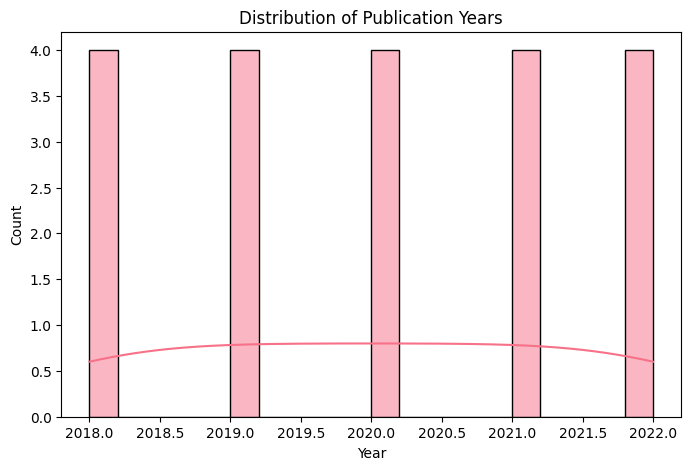

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['year'].dropna().astype(int), bins=20, kde=True)
plt.title('Distribution of Publication Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

## Count plot for categorical column 'is_unza_faculty'

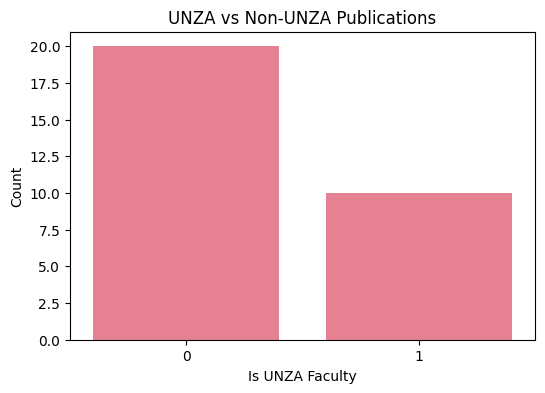

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='is_unza_faculty', data=df)
plt.title('UNZA vs Non-UNZA Publications')
plt.xlabel('Is UNZA Faculty')
plt.ylabel('Count')
plt.show()

## Top 10 most frequent publication venues

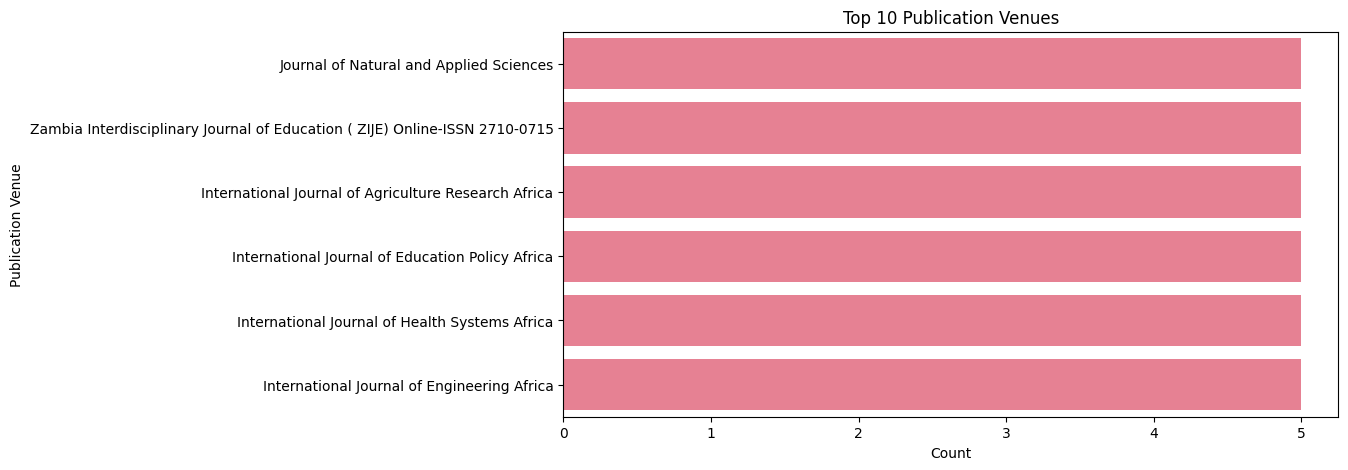

In [ ]:
plt.figure(figsize=(10,5))
top_venues = df['publication_venue'].value_counts().nlargest(10)
sns.barplot(x=top_venues.values, y=top_venues.index)
plt.title('Top 10 Publication Venues')
plt.xlabel('Count')
plt.ylabel('Publication Venue')
plt.show()

## Top 10 authors with most publications

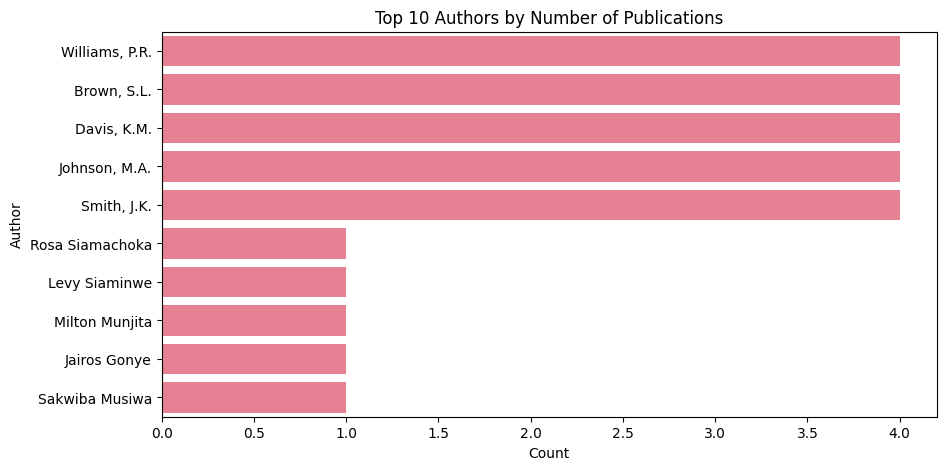

In [ ]:
plt.figure(figsize=(10,5))
top_authors = df['authors'].value_counts().nlargest(10)
sns.barplot(x=top_authors.values, y=top_authors.index)
plt.title('Top 10 Authors by Number of Publications')
plt.xlabel('Count')
plt.ylabel('Author')
plt.show()

## Summary Of Initial Findings

In [ ]:
print("\n=== Initial Findings Summary ===")
print(f"Total records: {len(df)}")
print(f"Total UNZA faculty publications: {df['is_unza_faculty'].sum()}")
print(f"Total Non-UNZA publications: {(df['is_unza_faculty'] == 0).sum()}")
print(f"Year range: {df['year'].min()} - {df['year'].max()}")
print("Top publication venues and authors are visualized above.")
print("Some missing abstracts and keywords exist, so cleaning may be needed before modeling.")


=== Initial Findings Summary ===
Total records: 30
Total UNZA faculty publications: 10
Total Non-UNZA publications: 20
Year range: 2018.0 - 2022.0
Top publication venues and authors are visualized above.
Some missing abstracts and keywords exist, so cleaning may be needed before modeling.


#3. Data Preparation
##3.1 Inspect Missing Values & Duplicates

Missing values can cause errors during modeling. Here we identify which columns have missing data.
We also check for duplicates, since duplicate publications could bias the model.

In [7]:
# Check for missing values
missing_counts = df.isnull().sum()
print("Missing values per column:")
print(missing_counts)

# Check for duplicates
duplicates = df.duplicated(subset=['title', 'authors']).sum()
print(f"\n Number of duplicate records based on title+authors: {duplicates}")


Missing values per column:
authors               0
title                 0
abstract              0
publication_venue     0
year                 10
keywords             10
source                0
is_unza_faculty       0
dtype: int64

 Number of duplicate records based on title+authors: 0


## 3.2 Handling Missing Values & Duplicates

In [8]:
# Drop rows with missing authors or title (essential features)
df = df.dropna(subset=['authors', 'title'])

# Remove duplicates
df = df.drop_duplicates(subset=['title', 'authors'], keep='first')

# Reset index
df = df.reset_index(drop=True)

print(f"Dataset after cleaning: {df.shape[0]} records")


Dataset after cleaning: 30 records


Rows with missing authors or title were removed because these are essential for author disambiguation.
Duplicate records were also removed to prevent over-representation of any publication in the training dataset.